In [1]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from arch.bootstrap import MCS

# Styling für Plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 11, 'figure.figsize': (10, 6)})

# Pfad-Setup: Wir suchen den Projekt-Root (wo 'src' und 'outputs' liegen)
def _locate_repo_root(start: Path) -> Path:
    cur = start.resolve()
    for _ in range(5):
        if (cur / 'src').exists(): return cur
        if cur.parent == cur: break
        cur = cur.parent
    return start.resolve()

PROJECT_ROOT = _locate_repo_root(Path.cwd())
STAGEB_DIR = PROJECT_ROOT / "outputs" / "stageB"

print(f"Project Root: {PROJECT_ROOT}")
print(f"Outputs Dir:  {STAGEB_DIR}")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

Project Root: /Users/jonasschernich/Documents/Masterarbeit/Code
Outputs Dir:  /Users/jonasschernich/Documents/Masterarbeit/Code/outputs/stageB


In [23]:
# =============================================================================
# KONFIGURATION & MODEL MAPPING
# =============================================================================

MODEL_MAPPING = {
    # --- SETUP I: Nur ifo Features ---
    "Setup_1": {
        # Exakte Namen gemäß Ihrer Angabe
        "ET (S1)":   {"path": "extra_trees_without_target", "family": "Trees"},

        # Falls diese auch existieren, lassen Sie sie drin, sonst auskommentieren:
        "LGBM (S1)": {"path": "lightgbm_without_target_mac", "family": "Boosting"},
        "ElNet (S1)":{"path": "elastic_net_without_target_700", "family": "Linear"},
    },

    # --- SETUP II: ifo + Target Features ---
    "Setup_2": {
        "ET (S2)":   {"path": "extra_trees_with_target",    "family": "Trees"},

        # Falls diese auch existieren:
        "ElNet (S2)":{"path": "elastic_net_with_target_700", "family": "Linear"},
        "LGBM (S2)": {"path": "lightgbm_with_target_mac",    "family": "Boosting"},
    },

    # --- BASELINES ---
    "Baselines": {
        "AR(1)":     {"path": "baseline_ar1",  "family": "Baseline"},
        "RW":        {"path": "baseline_rw",   "family": "Baseline"},
        "Hist.Mean": {"path": "baseline_mean", "family": "Baseline"},
    }

}

In [25]:
def load_predictions(mapping_dict, stage_dir):
    """Lädt preds.csv für alle Modelle im Mapping und merged sie."""
    dfs = []
    y_true = None
    meta = {}

    for name, info in mapping_dict.items():
        path = stage_dir / info["path"] / "monthly" / "preds.csv"

        if not path.exists():
            print(f"WARNUNG: Datei nicht gefunden für '{name}': {path}")
            continue

        try:
            df = pd.read_csv(path, parse_dates=["date_t_plus_1"])
            # Nur die vom Algorithmus gewählte ('active') Vorhersage nutzen
            df = df[df["is_active"] == True].copy()
            df = df.set_index("date_t_plus_1").sort_index()

            # Vorhersage speichern
            s_pred = df["y_pred"].rename(name)
            dfs.append(s_pred)

            # y_true beim ersten erfolgreichen Laden speichern
            if y_true is None:
                y_true = df["y_true"].rename("y_true")

            meta[name] = info
        except Exception as e:
            print(f"FEHLER bei {name}: {e}")

    if not dfs:
        return pd.DataFrame(), {}

    df_all = pd.concat([y_true] + dfs, axis=1).dropna()
    return df_all, meta

def calculate_dm_test(e1, e2, h=1):
    """Diebold-Mariano Test (HAC-korrigiert)."""
    d = e1**2 - e2**2
    if len(d) < 5: return 0.0, 1.0 # Zu wenig Daten
    # Regression auf Konstante
    res = sm.OLS(d, np.ones(len(d))).fit(cov_type='HAC', cov_kwds={'maxlags': h})
    return res.tvalues[0], res.pvalues[0]

def get_mcs_pvalues(losses_df):
    """Model Confidence Set (Bootstrap)."""
    if losses_df.shape[1] < 2: return {}
    # Block-Bootstrap für Zeitreihen
    mcs = MCS(losses_df, size=0.10, method="R", block_size=6)
    mcs.compute()
    return mcs.pvalues

In [26]:
# Alle Mappings zusammenführen
all_mappings = {}
for group in MODEL_MAPPING.values():
    all_mappings.update(group)

df_full, meta_full = load_predictions(all_mappings, STAGEB_DIR)

print(f"\nDaten geladen: {df_full.shape[0]} Monate, {df_full.shape[1]-1} Modelle.")
if not df_full.empty:
    display(df_full.head(3))
else:
    print("ACHTUNG: Keine Daten geladen. Überprüfe die Pfade im Mapping!")


Daten geladen: 166 Monate, 9 Modelle.


,y_true,ET (S1),LGBM (S1),ElNet (S1),ET (S2),ElNet (S2),LGBM (S2),AR(1),RW,Hist.Mean
date_t_plus_1,,,,,,,,,,
2011-03-01,0.307692,0.761767,0.268171,0.577945,0.454775,0.342689,-0.133132,0.024249,0.0,0.100910
2011-04-01,0.102249,0.598673,0.154437,0.493105,0.240673,0.197560,-0.342432,0.088868,0.0,0.101787
2011-05-01,0.919305,0.359357,0.101997,0.202492,0.493182,0.797755,0.701741,0.109682,0.0,0.101789



>>> TABLE R1 for Setup I (ifo Only) <<<


/var/folders/jl/__x0ybfj19qbrwgn16qjksvh0000gn/T/ipykernel_19994/3430279911.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return res.tvalues[0], res.pvalues[0]
/var/folders/jl/__x0ybfj19qbrwgn16qjksvh0000gn/T/ipykernel_19994/3430279911.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return res.tvalues[0], res.pvalues[0]
/var/folders/jl/__x0ybfj19qbrwgn16qjksvh0000gn/T/ipykernel_19994/3430279911.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

,Model,RMSE,MAE,DM (vs Best),MCS p-val,In MCS?
0,ET (S1),2.309302,1.396025,(Best),0.000,no
1,LGBM (S1),2.315589,1.441090,,0.000,no
2,ElNet (S1),2.312581,1.485336,,0.000,no


/var/folders/jl/__x0ybfj19qbrwgn16qjksvh0000gn/T/ipykernel_19994/3017146466.py:68: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(data=plot_data, x="Family", y="RMSE", errorbar=None,
/var/folders/jl/__x0ybfj19qbrwgn16qjksvh0000gn/T/ipykernel_19994/3017146466.py:68: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_data, x="Family", y="RMSE", errorbar=None,


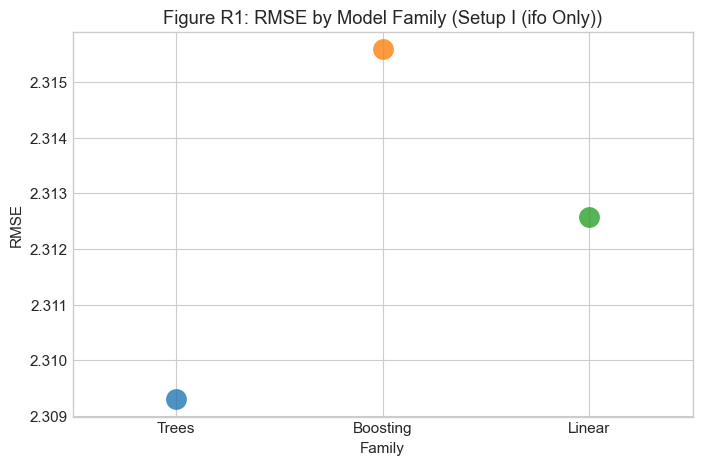


>>> TABLE R1 for Setup II (ifo + Targets) <<<


/var/folders/jl/__x0ybfj19qbrwgn16qjksvh0000gn/T/ipykernel_19994/3430279911.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return res.tvalues[0], res.pvalues[0]
/var/folders/jl/__x0ybfj19qbrwgn16qjksvh0000gn/T/ipykernel_19994/3430279911.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return res.tvalues[0], res.pvalues[0]
/var/folders/jl/__x0ybfj19qbrwgn16qjksvh0000gn/T/ipykernel_19994/3430279911.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

,Model,RMSE,MAE,DM (vs Best),MCS p-val,In MCS?
0,ET (S2),2.127005,0.999824,,0.000,no
1,ElNet (S2),2.048163,1.233680,,0.000,no
2,LGBM (S2),1.697285,0.848321,(Best),0.000,no


/var/folders/jl/__x0ybfj19qbrwgn16qjksvh0000gn/T/ipykernel_19994/3017146466.py:68: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(data=plot_data, x="Family", y="RMSE", errorbar=None,
/var/folders/jl/__x0ybfj19qbrwgn16qjksvh0000gn/T/ipykernel_19994/3017146466.py:68: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_data, x="Family", y="RMSE", errorbar=None,


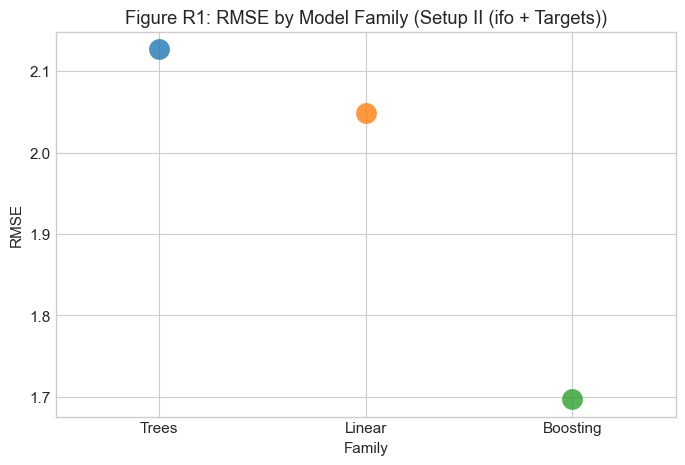

In [27]:
def evaluate_setup(setup_name, setup_dict, df_data, meta_data):
    # Filtern auf Modelle dieses Setups
    keys = [k for k in setup_dict.keys() if k in df_data.columns]
    if not keys:
        print(f"Keine Daten für {setup_name}")
        return

    # --- TABELLE R1 ERSTELLEN ---
    losses = pd.DataFrame(index=df_data.index)
    res = []

    # 1. Fehler berechnen
    for k in keys:
        err = df_data["y_true"] - df_data[k]
        losses[k] = err**2
        res.append({
            "Model": k,
            "RMSE": np.sqrt((err**2).mean()),
            "MAE": np.abs(err).mean()
        })

    df_res = pd.DataFrame(res).set_index("Model")
    best_model = df_res["RMSE"].idxmin()
    e_best = df_data["y_true"] - df_data[best_model]

    # 2. MCS & DM berechnen
    mcs_pvals = get_mcs_pvalues(losses)

    final_table = []
    for k in keys:
        rmse_val = df_res.loc[k, "RMSE"]
        mae_val = df_res.loc[k, "MAE"]

        # DM Test vs Best
        dm_sig = ""
        if k != best_model:
            e_curr = df_data["y_true"] - df_data[k]
            # Test: Ist Best signifikant besser als Curr?
            t, p = calculate_dm_test(e_curr, e_best) # d = curr^2 - best^2
            if p < 0.05 and t > 0: dm_sig = "***" # t>0 heißt curr hat größeren Fehler
            elif p < 0.10 and t > 0: dm_sig = "*"
        else:
            dm_sig = "(Best)"

        final_table.append({
            "Model": k,
            "RMSE": rmse_val,
            "MAE": mae_val,
            "DM (vs Best)": dm_sig,
            "MCS p-val": f"{mcs_pvals.get(k, 0):.3f}",
            "In MCS?": "YES" if mcs_pvals.get(k, 0) > 0.10 else "no"
        })

    print(f"\n>>> TABLE R1 for {setup_name} <<<")
    display(pd.DataFrame(final_table).style.highlight_min(subset=["RMSE", "MAE"], color="lightgreen"))

    # --- FIGURE R1: DOT PLOT ---
    plt.figure(figsize=(8, 5))

    # Daten für Plot vorbereiten
    plot_data = df_res.reset_index()
    plot_data["Family"] = plot_data["Model"].apply(lambda x: meta_data[x]["family"])

    sns.stripplot(data=plot_data, x="Family", y="RMSE", hue="Family",
                  s=15, jitter=False, alpha=0.8, legend=False)

    # Optional: Mittelwert-Strich pro Familie
    sns.pointplot(data=plot_data, x="Family", y="RMSE", errorbar=None,
                  color="black", markers="_", scale=0, join=False)

    plt.title(f"Figure R1: RMSE by Model Family ({setup_name})")
    plt.grid(axis='x')
    plt.show()

# Ausführen für Setup 1 und 2
evaluate_setup("Setup I (ifo Only)", MODEL_MAPPING["Setup_1"], df_full, meta_full)
evaluate_setup("Setup II (ifo + Targets)", MODEL_MAPPING["Setup_2"], df_full, meta_full)

/var/folders/jl/__x0ybfj19qbrwgn16qjksvh0000gn/T/ipykernel_19994/3430279911.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return res.tvalues[0], res.pvalues[0]
/var/folders/jl/__x0ybfj19qbrwgn16qjksvh0000gn/T/ipykernel_19994/3430279911.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return res.tvalues[0], res.pvalues[0]
/var/folders/jl/__x0ybfj19qbrwgn16qjksvh0000gn/T/ipykernel_19994/3430279911.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

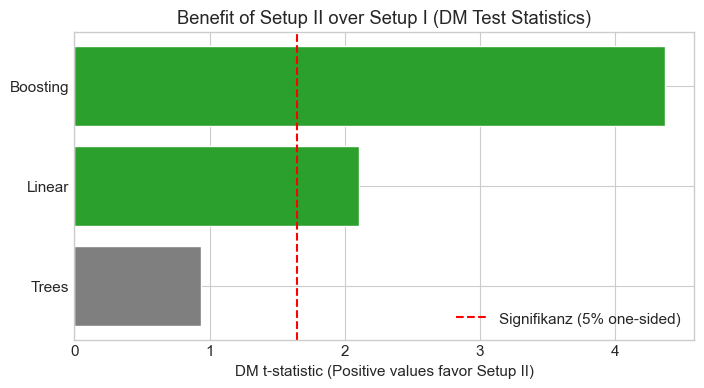

,Model S1,Model S2,t-stat,p-val
Family,,,,
Trees,ET (S1),ET (S2),0.939232,0.347612
Linear,ElNet (S1),ElNet (S2),2.105121,0.035281
Boosting,LGBM (S1),LGBM (S2),4.367349,0.000013


In [28]:
# Wir matchen Modelle anhand ihres Namens im Dictionary (z.B. "ET (S1)" vs "ET (S2)")
# Annahme: Die Reihenfolge/Familienzugehörigkeit definiert Paare oder man nutzt Namens-Konventionen.
# Hier ein generischer Ansatz: Vergleiche Modelle derselben Family.

families = set(info["family"] for info in meta_full.values())
comparisons = []

for fam in families:
    # Finde Modell dieser Familie in Setup 1
    mod_s1 = next((k for k, v in MODEL_MAPPING["Setup_1"].items() if v["family"] == fam and k in df_full.columns), None)
    # Finde Modell dieser Familie in Setup 2
    mod_s2 = next((k for k, v in MODEL_MAPPING["Setup_2"].items() if v["family"] == fam and k in df_full.columns), None)

    if mod_s1 and mod_s2:
        e1 = df_full["y_true"] - df_full[mod_s1]
        e2 = df_full["y_true"] - df_full[mod_s2]


        t_stat, p_val = calculate_dm_test(e1, e2)

        comparisons.append({
            "Family": fam,
            "Model S1": mod_s1,
            "Model S2": mod_s2,
            "t-stat": t_stat,
            "p-val": p_val
        })

if comparisons:
    df_comp = pd.DataFrame(comparisons).set_index("Family")

    plt.figure(figsize=(8, 4))
    # Farbe: Grün wenn signifikant positiv (Setup 2 besser), sonst grau
    colors = ["#2ca02c" if (r["t-stat"] > 1.645 and r["p-val"] < 0.1) else "#7f7f7f" for _, r in df_comp.iterrows()]

    bars = plt.barh(df_comp.index, df_comp["t-stat"], color=colors)
    plt.axvline(1.645, color="red", linestyle="--", label="Signifikanz (5% one-sided)")
    plt.title("Benefit of Setup II over Setup I (DM Test Statistics)")
    plt.xlabel("DM t-statistic (Positive values favor Setup II)")
    plt.legend()
    plt.show()

    display(df_comp)
else:
    print("Keine passenden Modellpaare für Vergleich gefunden.")

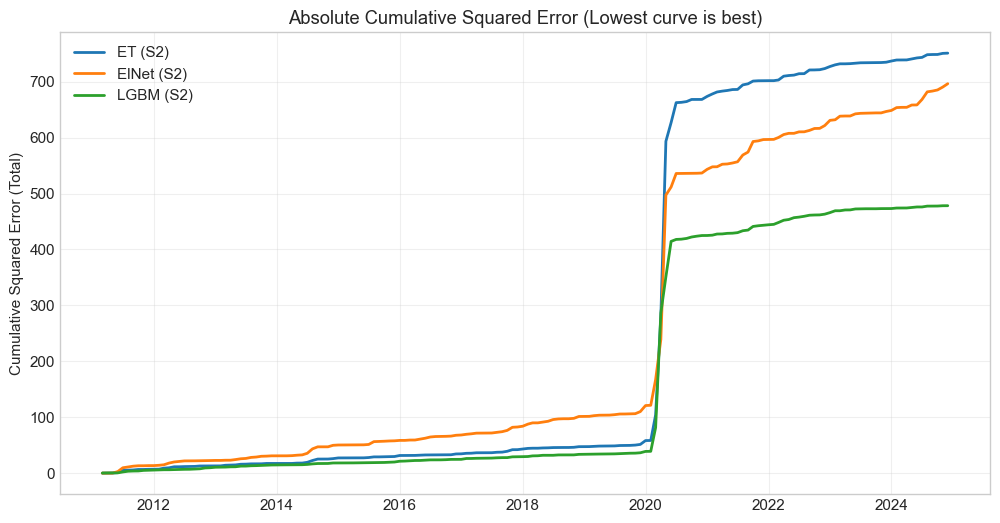

In [36]:
# === OPTION B: Absolute Cumulative Squared Error (Total Error) - OHNE Baseline ===
# Berechnung: CumSum(e_model^2) für alle
# Die unterste Linie ist das beste Modell.

if s2_keys:
    plt.figure(figsize=(12, 6))

    # (Baseline-Abschnitt entfernt)

    # 2. Modelle plotten
    for k in s2_keys:
        e_mod = (df_full["y_true"] - df_full[k])**2
        cse_mod = e_mod.cumsum()
        plt.plot(cse_mod.index, cse_mod, label=k, linewidth=2)

    plt.title("Absolute Cumulative Squared Error (Lowest curve is best)")
    plt.ylabel("Cumulative Squared Error (Total)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Referenz-Baseline: RW (RMSE: 2.3566)


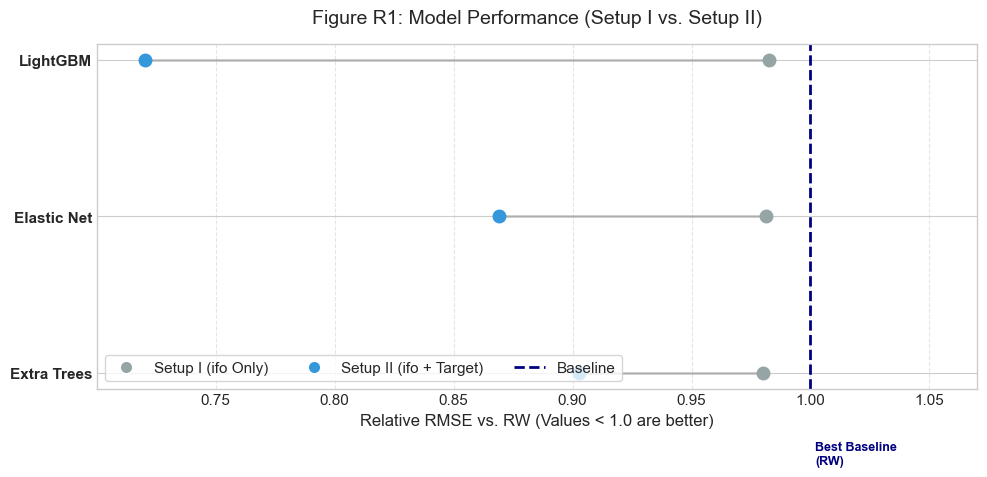

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D

# -------------------------------------------------------------------------
# SCHRITT A: Daten vorbereiten (Nur Setup I & II) -- KORRIGIERT
# -------------------------------------------------------------------------

# 1. Baseline Referenz (aus df_full)
baseline_keys = [k for k in MODEL_MAPPING["Baselines"].keys() if k in df_full.columns]
if not baseline_keys:
    print("WARNUNG: Keine Baseline-Daten gefunden!")
else:
    bl_rmse_dict = {k: np.sqrt(((df_full["y_true"] - df_full[k])**2).mean()) for k in baseline_keys}
    best_bl_name = min(bl_rmse_dict, key=bl_rmse_dict.get)
    best_bl_rmse = bl_rmse_dict[best_bl_name]
    print(f"Referenz-Baseline: {best_bl_name} (RMSE: {best_bl_rmse:.4f})")

    # 2. Daten sammeln (Nur Setup 1 und 2)
    data_rows = []
    # Setup 3 entfernt
    setup_defs = [
        ("Setup_1", "Setup I"),
        ("Setup_2", "Setup II")
    ]

    for setup_key, setup_label in setup_defs:
        if setup_key not in MODEL_MAPPING: continue

        for model_key, info in MODEL_MAPPING[setup_key].items():
            if model_key not in df_full.columns: continue

            # RMSE & Relativer RMSE
            rmse = np.sqrt(((df_full["y_true"] - df_full[model_key])**2).mean())
            rel_rmse = rmse / best_bl_rmse

            # --- HIER WAR DER FEHLER ---
            # Wir nehmen jetzt den Key (z.B. "ET (S1)") als Raw Name, da "name" im Dict fehlt
            raw_name = model_key

            base_name = raw_name
            # Falls nötig, Namen vereinfachen (z.B. "ET (S1)" -> "Extra Trees")
            if "Extra Tree" in raw_name or "ET" in raw_name: base_name = "Extra Trees"
            elif "Random Forest" in raw_name or "RF" in raw_name: base_name = "Random Forest"
            elif "LGBM" in raw_name or "LightGBM" in raw_name: base_name = "LightGBM"
            elif "ElNet" in raw_name or "Elastic" in raw_name: base_name = "Elastic Net"

            data_rows.append({
                "Model": base_name,
                "Setup": setup_label,
                "Rel_RMSE": rel_rmse
            })

    df_plot = pd.DataFrame(data_rows)

    # -------------------------------------------------------------------------
    # SCHRITT B: Plotten (Unverändert, aber hier zur Vollständigkeit)
    # -------------------------------------------------------------------------

    if not df_plot.empty:
        # Sortierung basierend auf Setup II Performance
        s2_models = df_plot[df_plot["Setup"] == "Setup II"]
        if not s2_models.empty:
            sort_order = s2_models.sort_values("Rel_RMSE", ascending=False)["Model"].unique()
        else:
            sort_order = df_plot.sort_values("Rel_RMSE", ascending=False)["Model"].unique()

        # Y-Positionen
        model_map_y = {m: i for i, m in enumerate(sort_order)}
        y_pos = np.arange(len(sort_order))

        # Farben (nur 2 Setups)
        colors = {"Setup I": "#95a5a6", "Setup II": "#3498db"}

        fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

        # Referenzlinie
        ax.axvline(1.0, color='navy', linewidth=2, linestyle='--', zorder=1)
        ax.text(1.002, -0.6, f"Best Baseline\n({best_bl_name})", color='navy',
                fontweight='bold', ha='left', va='bottom', fontsize=9)

        ax.grid(True, axis='x', linestyle='--', alpha=0.5)

        # Verbindungslinien (Range)
        for m in sort_order:
            sub = df_plot[df_plot['Model'] == m]
            if len(sub) > 1: # Nur verbinden wenn Punkte in beiden Setups da sind
                y = model_map_y[m]
                min_v = sub['Rel_RMSE'].min()
                max_v = sub['Rel_RMSE'].max()
                ax.hlines(y, min_v, max_v, color='gray', alpha=0.4, linewidth=2, zorder=2)

        # Punkte
        for setup in ["Setup I", "Setup II"]:
            sub = df_plot[df_plot['Setup'] == setup]
            for _, row in sub.iterrows():
                if row['Model'] not in model_map_y: continue
                y = model_map_y[row['Model']]
                ax.plot(row['Rel_RMSE'], y, marker='o', markersize=9,
                        markerfacecolor=colors[setup], markeredgecolor=colors[setup],
                        linestyle='', zorder=3)

        # Achsen & Titel
        ax.set_yticks(y_pos)
        ax.set_yticklabels(sort_order, fontsize=11, fontweight='bold')
        ax.set_xlabel(f"Relative RMSE vs. {best_bl_name} (Values < 1.0 are better)", fontsize=12)
        ax.set_title("Figure R1: Model Performance (Setup I vs. Setup II)", fontsize=14, pad=15)

        # X-Achse Limits
        xmin, xmax = df_plot["Rel_RMSE"].min(), df_plot["Rel_RMSE"].max()
        ax.set_xlim(min(xmin, 0.95) - 0.02, max(xmax, 1.05) + 0.02)

        # Legende (angepasst)
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor=colors["Setup I"], markersize=9, label='Setup I (ifo Only)'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor=colors["Setup II"], markersize=9, label='Setup II (ifo + Target)'),
            Line2D([0], [0], color='navy', linestyle='--', linewidth=2, label='Baseline')
        ]
        ax.legend(handles=legend_elements, loc='lower left', ncol=3, frameon=True)

        plt.tight_layout()
        plt.show()

Erstelle MCS Plot für Setup 1...


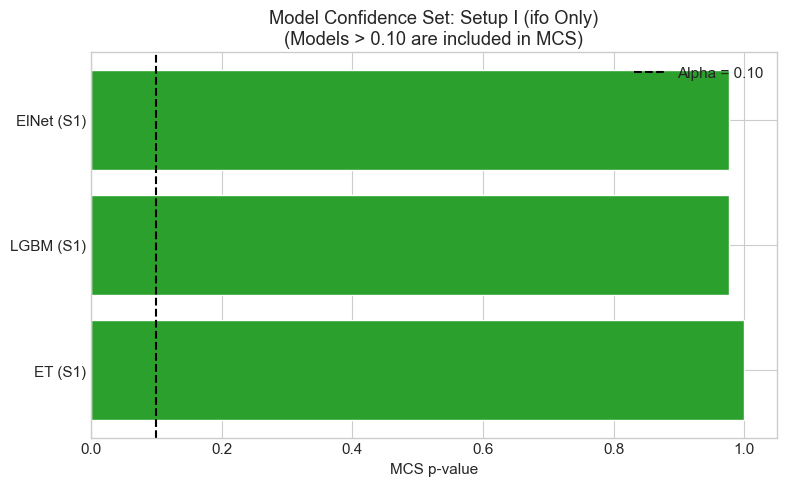


Erstelle MCS Plot für Setup 2...


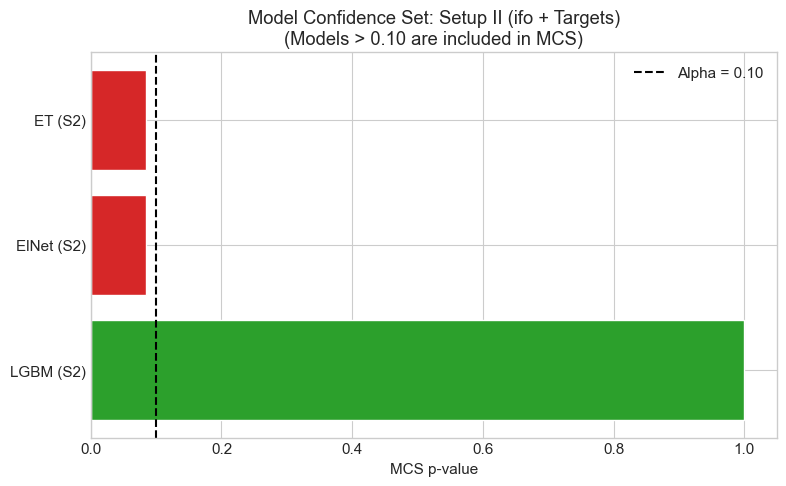

In [35]:
 def plot_mcs_bars(setup_name, setup_keys, df_data):
    """Plottet MCS p-Werte als Balkendiagramm."""
    keys = [k for k in setup_keys if k in df_data.columns]
    if len(keys) < 2:
        print(f"Zu wenige Modelle in {setup_name} für MCS.")
        return

    # Berechne Verluste & MCS
    losses = (df_data["y_true"].values[:, None] - df_data[keys].values)**2
    df_losses = pd.DataFrame(losses, columns=keys, index=df_data.index)

    # MCS berechnen
    mcs = MCS(df_losses, size=0.10, method="R", block_size=6)
    mcs.compute()
    pvals = mcs.pvalues

    # KORREKTUR HIER: Unterscheidung Series vs. DataFrame
    if isinstance(pvals, pd.DataFrame):
        # Falls es schon ein DataFrame ist, Spalte umbenennen für Konsistenz
        df_p = pvals.copy()
        df_p.columns = ["p-value"]
    else:
        # Falls es eine Series ist (alte arch Versionen), in DataFrame wandeln
        df_p = pvals.to_frame("p-value")

    # Sortieren und Plotten (wie zuvor)
    df_p = df_p.sort_values("p-value", ascending=False)

    plt.figure(figsize=(8, 5))
    # Farbe: Grün wenn im Set (>0.1), Rot wenn draußen
    colors = ["#2ca02c" if p > 0.1 else "#d62728" for p in df_p["p-value"]]

    plt.barh(df_p.index, df_p["p-value"], color=colors)
    plt.axvline(0.10, color="black", linestyle="--", linewidth=1.5, label="Alpha = 0.10")

    plt.title(f"Model Confidence Set: {setup_name}\n(Models > 0.10 are included in MCS)")
    plt.xlabel("MCS p-value")
    plt.legend()
    plt.tight_layout()
    plt.show()
# --- HIER DIE FUNKTION AUFRUFEN ---

print("Erstelle MCS Plot für Setup 1...")
plot_mcs_bars("Setup I (ifo Only)", MODEL_MAPPING["Setup_1"].keys(), df_full)

print("\nErstelle MCS Plot für Setup 2...")
plot_mcs_bars("Setup II (ifo + Targets)", MODEL_MAPPING["Setup_2"].keys(), df_full)

In [34]:
# =============================================================================
# MISSING PIECE 3: Best-of-Family vs. Baselines (Detailed Plots)
# =============================================================================

# Welche Setup-Modelle nutzen wir als Challenger? (z.B. alle aus Setup 2)
challenger_keys = list(MODEL_MAPPING["Setup_2"].keys())
# Welche Familien gibt es?
families = sorted(list(set(meta_full[k]["family"] for k in challenger_keys if k in df_full.columns)))

# Für jede Baseline einen Plot
for bl_key in MODEL_MAPPING["Baselines"].keys():
    if bl_key not in df_full.columns: continue

    print(f"\nGeneriere Plot für Benchmark: {bl_key}...")

    e_bl = df_full["y_true"] - df_full[bl_key]
    plot_data = []

    # Finde das beste Modell pro Familie
    for fam in families:
        fam_models = [k for k in challenger_keys if k in df_full.columns and meta_full[k]["family"] == fam]
        if not fam_models: continue

        # Welches Modell in dieser Familie hat den kleinsten RMSE?
        best_fam_rmse = float("inf")
        best_fam_model = None

        for m in fam_models:
            rmse_m = np.sqrt(((df_full["y_true"] - df_full[m])**2).mean())
            if rmse_m < best_fam_rmse:
                best_fam_rmse = rmse_m
                best_fam_model = m

        # Vergleiche dieses "Best of Family" Modell gegen die Baseline
        e_mod = df_full["y_true"] - df_full[best_fam_model]

        # DM Test (Positiv = Modell ist besser als Baseline)
        # d = err_baseline^2 - err_model^2
        t_stat, p_val = calculate_dm_test(e_bl, e_mod)

        # Signifikanz-Sternchen
        sig_label = ""
        if p_val < 0.05 and t_stat > 0: sig_label = "***"
        elif p_val < 0.10 and t_stat > 0: sig_label = "*"

        plot_data.append({
            "Family": fam,
            "BestModel": meta_full[best_fam_model]["name"],
            "t-stat": t_stat,
            "p-val": p_val,
            "sig_label": sig_label
        })

    if not plot_data: continue

    df_p = pd.DataFrame(plot_data)

    # PLOT
    plt.figure(figsize=(9, 5))

    # Farbe: Grün wenn Modell signifikant besser als Baseline
    colors = ["#2ca02c" if (row["t-stat"] > 1.645 and row["p-val"] < 0.1) else "grey" for _, row in df_p.iterrows()]

    bars = plt.bar(df_p["Family"], df_p["t-stat"], color=colors)
    plt.axhline(0, color="black", lw=1)
    plt.axhline(1.645, color="red", linestyle="--", label="Sig. Threshold (5%)")

    # Beschriftung der Balken mit dem Namen des besten Modells
    for bar, name, sig in zip(bars, df_p["BestModel"], df_p["sig_label"]):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1,
                 f"{name}\n{sig}", ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.title(f"Can Model Families beat {meta_full[bl_key]['name']}?\n(Best Setup II Model per Family vs Benchmark)")
    plt.ylabel("DM t-statistic (Positive = Model beats Baseline)")
    plt.ylim(bottom=min(df_p["t-stat"].min(), -1) - 0.5, top=max(df_p["t-stat"].max(), 2.5) + 1)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()


Generiere Plot für Benchmark: AR(1)...


/var/folders/jl/__x0ybfj19qbrwgn16qjksvh0000gn/T/ipykernel_19994/3430279911.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return res.tvalues[0], res.pvalues[0]
/var/folders/jl/__x0ybfj19qbrwgn16qjksvh0000gn/T/ipykernel_19994/3430279911.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return res.tvalues[0], res.pvalues[0]


KeyError: 'name'